In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML, Javascript
display(HTML('<style>.container { width:90% !important; }</style>'))

from collections import OrderedDict
import csv
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.width',170, 'display.max_rows',20, 'display.max_columns',30)
import sys
from time import time
import warnings
warnings.simplefilter("ignore")

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
import lightgbm as lgb
import pickle
from scipy.sparse import save_npz
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras import backend, models, layers, utils

from metrics import BinaryClassificationMetrics

THOU = lambda x:'{:,}'.format(x)

## Depression Analysis

#### Parameters

In [3]:
param = dict(
    NB_NAME = 'Depression Analysis',

    DIR = './',

    #seed for random number generator
    SEED = 123456,

    #percentage of dataset used in training
    TRAIN_PCT = 80,

    #range of ngrams to be included in model
    NGRAM_RANGE = (1,1),

    #minimum word frequency (as a percentage) in training data for word to be part of vocabulary
    #.1 => 1 in 1000
    MIN_DF_PCT = .1,

    #number of folds in cross validation
    XVAL_FOLDS = 4,

    #max predictors
    GLM_MAX_PRED = 200,

    #number of threads to be used on the machine
    NUM_THREAD = 8
)
param

ignore_words = set(['adrienne_wf', 'amp', 'brookemiccio', 'casey', 'co', 'daniandkaceyfan', 
            'daniellecarolan', 'don', 'fuck', 'fucked', 'fucking', 'hairodynamic', 'https', 'https co', 
            'itscaitlinbea', 'jeanineamapola', 'kenzie', 'kenzieelizabeth', 'khoa_nguyen', 'la', 
            'lifeaseva', 'lyssryann', 'maddymcq', 'michaelnorco', 'michellexxo', 'missremiashten', 
            'mollybails', '_morganyates', 'nashville', 'nicholejacklyne', 'patheticutter', 're', 
            'sierra_furtado', 'tanamontana100', 'tastypinkbun', 'texas', 'theglenn_coco', 'this', 'to', 
            'via', 'video', 'vlog', 'xx', 'youtube', '000']) | set(map(str, range(1,10000)))
print('Ignoring {:,} words'.format(len(ignore_words)))

{'NB_NAME': 'Depression Analysis',
 'DIR': './',
 'SEED': 123456,
 'TRAIN_PCT': 80,
 'NGRAM_RANGE': (1, 1),
 'MIN_DF_PCT': 0.1,
 'XVAL_FOLDS': 4,
 'GLM_MAX_PRED': 200,
 'NUM_THREAD': 8}

Ignoring 10,044 words


#### Read Data

In [4]:
depr_pd = pd.read_table(param['DIR']+'/depressed_tweets.csv', delimiter='|', quotechar='"', quoting=csv.QUOTE_MINIMAL)
depr_pd['label'] = 1

norm_pd = pd.read_table(param['DIR']+'/normal_tweets.csv', delimiter='|', quotechar='"', quoting=csv.QUOTE_MINIMAL)
norm_pd['label'] = 0

data_pd = pd.concat([depr_pd,norm_pd])[['label','Tweet']].reset_index(drop=True)
data_pd.columns = map(str.lower, data_pd.columns)
pd.pivot_table(data_pd.groupby('label').size().reset_index(name='counts'),
               values='counts', index=['label'], aggfunc=np.sum, margins=True).loc[[1,0,'All']].applymap(THOU)

print('\n','Sample from dataset')
data_pd.sample(6, random_state=123456).style.set_properties(subset=['tweet'], **{'width': '600px'})

del depr_pd, norm_pd

,counts
label,
1,"31,030"
0,"42,914"
All,"73,944"



 Sample from dataset


,label,tweet
6934,1,I’m trying to not cut but it’s so hard not to
55774,0,@ingridnilsen I don't know what happened. I'm blaming the pan 😐🚣 #girlspan #wut
25961,1,I'm the princess without a prince because I'm tough enough to get through life without someone holding my hand.
59551,0,Can't wait to get out and ride this baby tomorrow🏄 https://t.co/BvTCr3FM46
28760,1,i think i’ll spend the day imagining the worst
28398,1,not having a crush on anyone is going to kill me


#### Pre-process

In [5]:
print('\nReplace all unicode characters')
data_pd['tweet'] = data_pd['tweet'].replace({r'[^\x00-\x7F]+':' '}, regex=True)

print('\nSplit into Train %.0f%% and Test %.0f%%'%(param['TRAIN_PCT'],100.-param['TRAIN_PCT']))
np.random.seed(param['SEED'])
data_pd['train'] = np.random.random(len(data_pd))<.01*param['TRAIN_PCT']
pd.pivot_table(data_pd.groupby(['train','label']).size().reset_index(name='counts'), 
        values='counts', index=['label'], columns=['train'], aggfunc=np.sum, margins=True).loc[
            [1,0,'All']].applymap(THOU)

print('\nSplit Train into folds (test data is in fold 0)')
data_pd['fold'] = 0
data_pd.loc[data_pd['train'], 'fold'] = np.random.randint(low=1, high=1+param['XVAL_FOLDS'], size=sum(data_pd['train']))
pd.pivot_table(data_pd.groupby(['fold','label']).size().reset_index(name='counts'), 
        values='counts', index=['label'], columns=['fold'], margins=True, aggfunc=np.sum).loc[
            [1,0,'All']].applymap(THOU)

print('\nSample from dataset')
data_pd.sample(4, random_state=123456).style.set_properties(subset=['tweet'], **{'width': '500px'})


Replace all unicode characters

Split into Train 80% and Test 20%


train,False,True,All
label,,,
1,"6,284","24,746","31,030"
0,"8,840","34,074","42,914"
All,"15,124","58,820","73,944"



Split Train into folds (test data is in fold 0)


fold,0,1,2,3,4,All
label,,,,,,
1,"6,284","6,098","6,196","6,268","6,184","31,030"
0,"8,840","8,544","8,592","8,475","8,463","42,914"
All,"15,124","14,642","14,788","14,743","14,647","73,944"



Sample from dataset


,label,tweet,train,fold
6934,1,I m trying to not cut but it s so hard not to,True,1
55774,0,@ingridnilsen I don't know what happened. I'm blaming the pan #girlspan #wut,True,3
25961,1,I'm the princess without a prince because I'm tough enough to get through life without someone holding my hand.,True,2
59551,0,Can't wait to get out and ride this baby tomorrow https://t.co/BvTCr3FM46,True,4


#### Determine Vocabulary

In [6]:
print('Computing size of vocabulary at different thresholds of document frequency')
mindf,sz = [0,.01,.1,.5,1,2,5],[]
print('Current: ', end='')
for pct in mindf:
    print(pct, end=' ')
    count_vect = CountVectorizer(ngram_range=param['NGRAM_RANGE'], min_df=.01*pct)
    counts_train = count_vect.fit_transform(data_pd[data_pd['train']]['tweet'].tolist())
    sz.append(len(count_vect.vocabulary_))

mindf_pd = pd.DataFrame(dict(min_df_pct=list(map(lambda x:'%.02f%%'%x,mindf)), vocab_sz=sz))
mindf_pd['vocab_sz'] = mindf_pd['vocab_sz'].apply(THOU)
mindf_pd

del counts_train, count_vect, mindf, pct, sz

Computing size of vocabulary at different thresholds of document frequency
Current: 0 0.01 0.1 0.5 1 2 5 

,min_df_pct,vocab_sz
0,0.00%,"42,077"
1,0.01%,"5,772"
2,0.10%,"1,048"
3,0.50%,298
4,1.00%,151
5,2.00%,84
6,5.00%,30


#### Create Model Matrices

In [7]:
#create vocabulary
count_vect = CountVectorizer(ngram_range=param['NGRAM_RANGE'], min_df=.01*param['MIN_DF_PCT'])
X_train = count_vect.fit_transform(data_pd[data_pd['train']]['tweet'].tolist())
print('X_train: {:,} x {:,}'.format(*X_train.shape))

vocab = list(set(count_vect.vocabulary_.keys())-ignore_words)
print('\nvocabulary: {:s} (dropping words in ignore list)'.format(THOU(len(vocab))))

#training matrix using updated vocabulary
count_vect = CountVectorizer(ngram_range=param['NGRAM_RANGE'], vocabulary=vocab)
X_train = count_vect.transform(data_pd[data_pd['train']]['tweet'].tolist())
X_train.data = np.ones(X_train.data.shape[0])
print('\nX_train: {:,} x {:,}'.format(*X_train.shape))

y_train = data_pd.loc[data_pd['train'], 'label'].values
print('y_train: {:,}'.format(*y_train.shape))

folds = data_pd.loc[data_pd['train'], 'fold'].values
print('folds: {:,}'.format(*folds.shape))

#test matrix with same vocabulary
X_test = count_vect.transform(data_pd[~data_pd['train']]['tweet'].tolist())
X_test.data = np.ones(X_test.data.shape[0])
print('\nX_test:  {:,} x {:,}'.format(*X_test.shape))

y_test = data_pd.loc[~data_pd['train'], 'label'].values
print('y_train: {:,}'.format(*y_test.shape))

print('\nUsing binary model matrices for generalization. Replaced word frequency with 1s.')
del count_vect

X_train: 58,820 x 1,048

vocabulary: 991 (dropping words in ignore list)

X_train: 58,820 x 991
y_train: 58,820
folds: 58,820

X_test:  15,124 x 991
y_train: 15,124

Using binary model matrices for generalization. Replaced word frequency with 1s.


#### Save to disk

In [8]:
save_npz('saved/X_train', matrix=X_train)
np.save('saved/y_train', y_train)
save_npz('saved/X_test', matrix=X_test)
np.save('saved/y_test', y_test)

with open('saved/vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

### GLM Model Using h2o

In [9]:
h2o.init(ip='localhost', port=54321, nthreads=param['NUM_THREAD'], min_mem_size='12g')
#h2o.init(ip='localhost', port=60111)
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from c:\python37\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\DOWNLO~1\Temp\tmp33b34j8f
  JVM stdout: C:\DOWNLO~1\Temp\tmp33b34j8f\h2o_Divya_Nori_started_from_python.out
  JVM stderr: C:\DOWNLO~1\Temp\tmp33b34j8f\h2o_Divya_Nori_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,05 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_Divya_Nori_hcf8lj
H2O cluster total nodes:,1
H2O cluster free memory:,11.50 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


#### Load data into h2o

In [10]:
start = time()
train_h2o = h2o.H2OFrame(X_train)
train_h2o = train_h2o.cbind(h2o.H2OFrame(np.c_[y_train,folds]))
train_h2o.names = vocab + ['label','fold']
print('train_h2o: {:,} x {:,} (including label, fold)'.format(*train_h2o.shape))

test_h2o = h2o.H2OFrame(X_test)
test_h2o = test_h2o.cbind(0)
test_h2o.names = vocab + ['fold']
print('test_h2o: {:,} x {:,} (no label, fold=0)'.format(*test_h2o.shape))

print('\n  time: {0:.1f}min'.format((time()-start)/60.))

train_h2o: 58,820 x 993 (including label, fold)
test_h2o: 15,124 x 992 (no label, fold=0)

  time: 0.2min


#### Create Regularization Path

In [11]:
start = time()

glm_h2o = H2OGeneralizedLinearEstimator(family='binomial', alpha=1., lambda_search=True, nlambdas=100, seed=param['SEED'])
glm_h2o.train(y='label', training_frame=train_h2o, fold_column='fold')

try:
    key_lambdas = dict(map(lambda x:tuple(x.split(' = ')), glm_h2o.summary()['lambda_search'][0].split(', ')))
    key_lambdas = dict((k,float(v)) for k,v in key_lambdas.items() if k not in {'nlambda'})
except:
    key_lambdas = dict()
    print('Unable to parse lambda summary')
print('Key lambdas:', key_lambdas)

regpath_h2o = H2OGeneralizedLinearEstimator.getGLMRegularizationPath(glm_h2o)
regpath_pd = pd.DataFrame(index=np.arange(len(regpath_h2o['lambdas'])), columns=['lambda','ncoef','auc'])
for n,(lamb,coefs) in enumerate(zip(regpath_h2o['lambdas'],regpath_h2o['coefficients'])):
    mod = H2OGeneralizedLinearEstimator.makeGLMModel(model=glm_h2o, coefs=coefs)
    regpath_pd.loc[n] = [lamb, sum(1 for x in coefs.values() if abs(x)>1E-3), mod.model_performance(train_h2o).auc()]
    h2o.remove(mod)

print('\n  time: {0:.1f}min'.format((time()-start)/60.))
del glm_h2o, mod, regpath_h2o

Key lambdas: {'lambda.max': 0.05865, 'lambda.min': 0.0003204, 'lambda.1se': 0.0009784}

  time: 1.0min


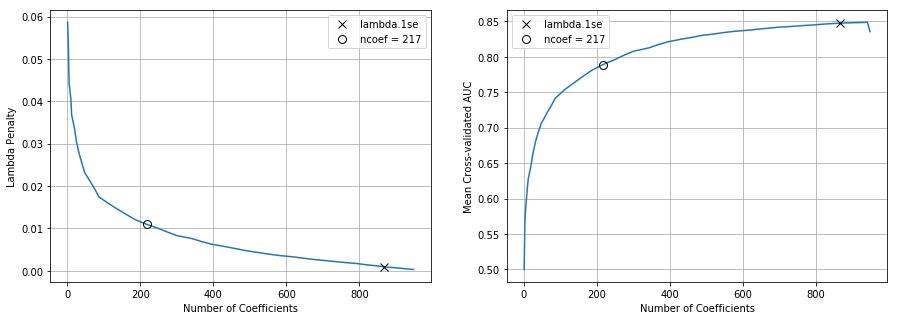

In [12]:
idx1 = np.abs(regpath_pd['lambda'].values-key_lambdas['lambda.1se']).argmin()
idx2 = np.argmax(regpath_pd['ncoef'].values>=param['GLM_MAX_PRED'])

fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(121),fig.add_subplot(122)]
for n in range(len(ax)):
    s = 'auc' if n else 'lambda'
    _ = ax[n].plot(regpath_pd['ncoef'].values, regpath_pd[s].values)
    _ = ax[n].plot(regpath_pd.loc[idx1,'ncoef'], regpath_pd.loc[idx1,s], 'x', color='k', ms=8,
                   zorder=200, label='lambda.1se')
    _ = ax[n].plot(regpath_pd.loc[idx2,'ncoef'], regpath_pd.loc[idx2,s], 'o', color='k', ms=8, 
                   markerfacecolor='none', zorder=200, label='ncoef = {}'.format(regpath_pd.loc[idx2,'ncoef']))
    _ = ax[n].set_xlabel('Number of Coefficients')
    _ = ax[n].set_ylabel('Mean Cross-validated AUC' if n else 'Lambda Penalty')
    _ = ax[n].legend()
    _ = ax[n].grid()

del idx1, idx2, fig, ax

#### Create Final Model and Predict

In [13]:
idx = np.argmax(regpath_pd['ncoef'].values>=param['GLM_MAX_PRED'])
regpath_pd.iloc[[idx]]
use_lambda = regpath_pd.loc[idx,'lambda']

glm_h2o = H2OGeneralizedLinearEstimator(family='binomial', alpha=1., lambda_search=False, Lambda=use_lambda, seed=param['SEED'])
glm_h2o.train(y='label', training_frame=train_h2o, fold_column='fold')

predict_pd = data_pd.copy(deep=True)[['label']]
predict_pd['score'] = 0
predict_pd.loc[data_pd['train'],'score'] = glm_h2o.predict(train_h2o).as_data_frame()['p1'].values
predict_pd.loc[~data_pd['train'],'score'] = glm_h2o.predict(test_h2o).as_data_frame()['p1'].values

,lambda,ncoef,auc
18,0.0109902,217,0.78907


#### Performance Metrics

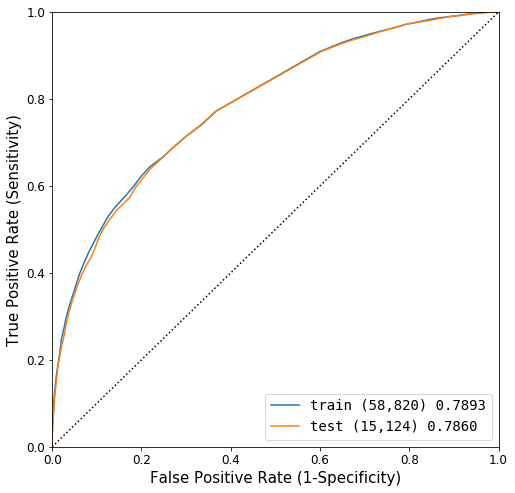

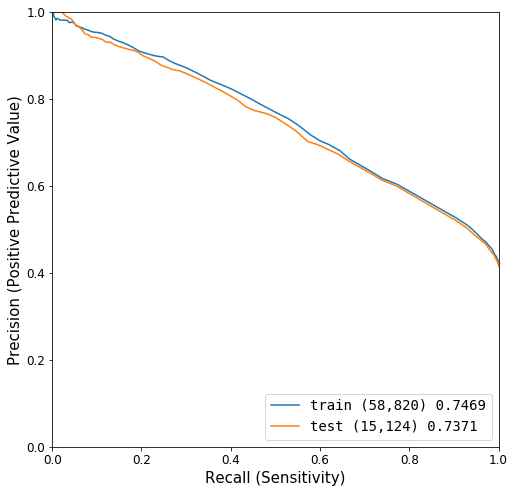

In [14]:
bcm_glm = BinaryClassificationMetrics()
bcm_glm.addModel('train', predict_pd[data_pd['train']])
bcm_glm.addModel('test', predict_pd[~data_pd['train']])

bcm_glm.plotROC(params={'legloc':4})

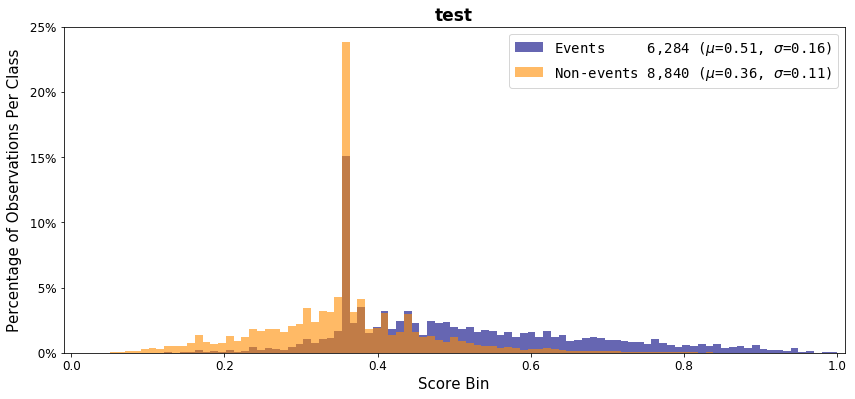

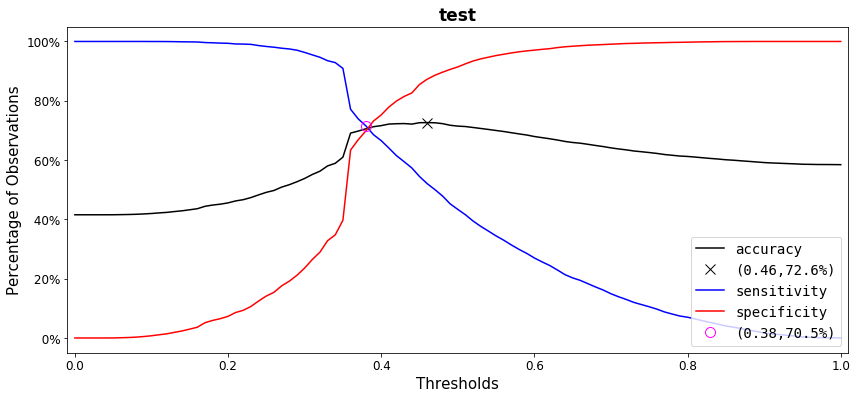

In [15]:
bcm_glm.plot(model_names=['test'], chart_types=[1,3])

In [16]:
bcm_glm.confusionMatrixKeyValue(key='f1')

,model,thresh,tp,tn,fp,fn,sens,spec,ppv,npv,accu,prev,lift,f1
0,train,0.36,19132,21498,12576,5614,0.773135,0.630921,0.603381,0.792933,0.690751,0.420707,1.837703,0.677791
1,test,0.36,4847,5603,3237,1437,0.771324,0.633824,0.599579,0.795881,0.690955,0.415499,1.856382,0.674694


#### Coefficients

In [17]:
coef_dt = glm_h2o._model_json['output']['coefficients_table'].as_data_frame()[['names','coefficients']]
coef_dt = coef_dt[abs(coef_dt['coefficients'])>1E-3].reset_index(drop=True)
coef_dt.to_csv('coefficients.txt', index=False)

coef_dt['sorted'] = np.abs(coef_dt['coefficients'])
coef_dt = coef_dt.sort_values('coefficients', ascending=False).drop(['sorted'], axis=1)

with pd.option_context('display.max_rows', 20, 'display.max_columns', None):
    coef_dt

,names,coefficients
46,pain,1.398537
40,depression,1.346171
80,fat,1.338551
77,death,1.139708
110,die,1.079382
126,alone,1.015601
33,disappointment,0.988867
64,depressed,0.971719
18,shit,0.947672
92,happiness,0.926700


In [18]:
del bcm_glm, coef_dt, glm_h2o, predict_pd, regpath_pd

#h2o.remove_all()
#h2o.cluster().shutdown()

### GBM Model Using LightGBM

#### Parameter Description
<pre>
boosting_type      method used in boosting (gbdt); gbdt=gradient boosting decision tree, rf=random forest
feature_fraction   randomly select part of features on each iteration
learning_rate      shrinkage rate (.1)
min_data_in_leaf   minimal number of rows of data in one leaf. Can be used to deal with over-fitting (20)
num_boost_round    number of boosting iterations (100)
num_leaves         max number of leaves in one tree (31)
</pre>

In [19]:
train_lgb = lgb.Dataset(X_train, y_train, feature_name=vocab).construct()
print('#row in train_gbm: {:s}'.format(THOU(train_lgb.num_data())))

#row in train_gbm: 58,820


In [20]:
def fold_gen():
    for n in range(1,param['XVAL_FOLDS']+1):
        yield np.where(folds!=n)[0], np.where(folds==n)[0]

#### Grid Search

In [21]:
start = time()

metric = 'binary_logloss'
param_fixed = dict(objective='binary', boosting_type='gbdt', metric=metric, num_thread=param['NUM_THREAD'],
                   num_boost_round=300, early_stopping_rounds=5, seed=param['SEED'])

param_grid = OrderedDict([
    ('learning_rate',    [.01, .015]),
    ('num_leaves',       [63, 31]),
    ('feature_fraction', [.2, .25]),
    ('min_data_in_leaf', [125, 100, 150])
])
param_cart = list(itertools.product(*param_grid.values()))

def lgb_cv(vals):
    prm = {**param_fixed, **dict(zip(param_grid.keys(),vals))}
    out = lgb.cv(prm, train_lgb, folds=fold_gen(), verbose_eval=0, show_stdv=False)
    return(list(vals)+[out[metric+'-mean'][-1],len(out[metric+'-mean'])])

print('Current best after N searches (total {})'.format(len(param_cart)),'\n')
result,st = list(),time()       
for n,x in enumerate(param_cart,1):
    print(n, end=' '); sys.stdout.flush()
    result.append(lgb_cv(x))
    if n%10==0 or n==len(param_cart):
        print(' ({0:.1f}min)'.format((time()-st)/60.)); st = time()
        tmp = pd.DataFrame(result, columns=list(param_grid.keys())+[metric+'-mean','nboost'])
        print(tmp.sort_values([metric+'-mean'])[:3], '\n')

print('  time: {0:.1f}min'.format((time()-start)/60.))
del param_cart

Current best after N searches (total 24) 

1 2 3 4 5 6 7 8 9 10  (3.7min)
   learning_rate  num_leaves  feature_fraction  min_data_in_leaf  binary_logloss-mean  nboost
4           0.01          63              0.25               100             0.564167     300
3           0.01          63              0.25               125             0.569475     300
1           0.01          63              0.20               100             0.570743     300 

11 12 13 14 15 16 17 18 19 20  (3.7min)
    learning_rate  num_leaves  feature_fraction  min_data_in_leaf  binary_logloss-mean  nboost
16          0.015          63              0.25               100             0.543520     300
15          0.015          63              0.25               125             0.548858     300
13          0.015          63              0.20               100             0.549853     300 

21 22 23 24  (1.2min)
    learning_rate  num_leaves  feature_fraction  min_data_in_leaf  binary_logloss-mean  nboost
16       

#### Results sorted on binary_logloss

In [22]:
gridresult_pd = pd.DataFrame(result, columns=list(param_grid.keys())+[metric+'-mean','nboost'])
gridresult_pd = gridresult_pd.sort_values([metric+'-mean']).reset_index(drop=True)
with pd.option_context("display.max_rows",40):
    gridresult_pd

,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,binary_logloss-mean,nboost
0,0.015,63,0.25,100,0.543520,300
1,0.015,63,0.25,125,0.548858,300
2,0.015,63,0.20,100,0.549853,300
3,0.015,63,0.25,150,0.555256,300
4,0.015,63,0.20,125,0.555823,300
5,0.015,31,0.25,100,0.555881,300
6,0.015,31,0.25,125,0.558369,300
7,0.015,31,0.20,100,0.559095,300
8,0.015,31,0.25,150,0.562003,300
9,0.015,63,0.20,150,0.562118,300


#### Create Final Model and Predict

In [23]:
model_index_selected = 0

start = time()
tmp = gridresult_pd.iloc[model_index_selected].to_dict()
param_final = {**param_fixed, **tmp}
param_final['num_boost_round'] = param_final['nboost']

for x in ['num_leaves','min_data_in_leaf','num_boost_round']:
    if x in param_final:
        param_final[x] = int(param_final[x])
for x in ['early_stopping_rounds','nboost','binary_logloss-mean']:
    if x in param_final:
        del param_final[x]
print('param_final:', param_final, '\n')

model_gbm = lgb.train(param_final, train_lgb, verbose_eval=False)
_ = model_gbm.save_model(filename='saved/lgbm.txt')

print('  time: {0:.1f}min'.format((time()-start)/60.))
del model_index_selected, param_final, tmp

param_final: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'binary_logloss', 'num_thread': 8, 'num_boost_round': 300, 'seed': 123456, 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 0.25, 'min_data_in_leaf': 100} 

  time: 0.1min


In [24]:
tmp1 = data_pd[data_pd['train']==True][['train','label']].reset_index(drop=True)
tmp1['score'] = model_gbm.predict(X_train)
tmp2 = data_pd[data_pd['train']==False][['train','label']].reset_index(drop=True)
tmp2['score'] = model_gbm.predict(X_test)

predict_gbm_pd = pd.concat([tmp1,tmp2]).reset_index(drop=True)
predict_gbm_pd.rename({'is_case':'label'}, axis='columns', inplace=True)
predict_gbm_pd['label'] = predict_gbm_pd['label'].astype(np.int8)

del tmp1, tmp2

#### Performance Metrics

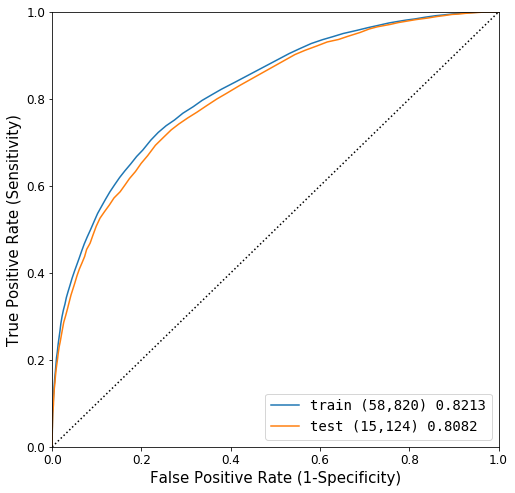

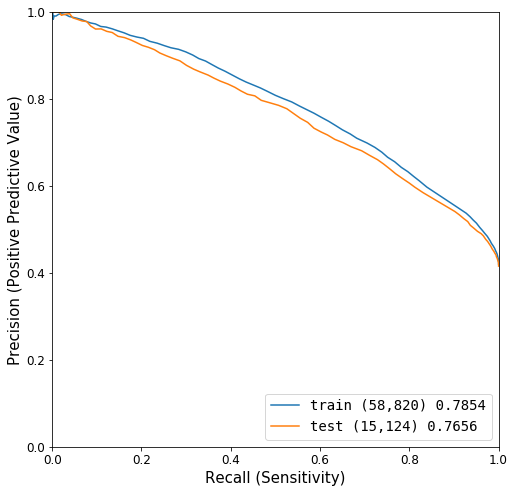

In [25]:
bcm_gbm = BinaryClassificationMetrics()
bcm_gbm.addModel('train', predict_gbm_pd.loc[predict_gbm_pd['train'], ['label','score']])
bcm_gbm.addModel('test', predict_gbm_pd.loc[~predict_gbm_pd['train'], ['label','score']])

bcm_gbm.plotROC(params={'legloc':4})

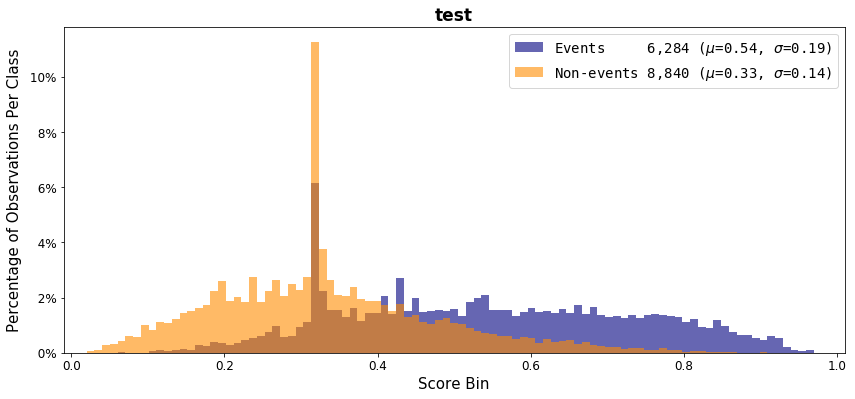

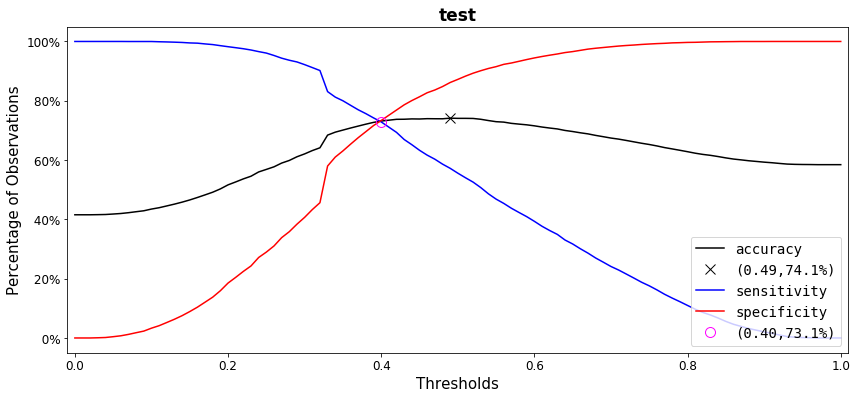

In [26]:
bcm_gbm.plot(model_names=['test'], chart_types=[1,3])

In [27]:
bcm_gbm.confusionMatrixKeyValue(key='f1')

,model,thresh,tp,tn,fp,fn,sens,spec,ppv,npv,accu,prev,lift,f1
0,train,0.38,18982,24099,9975,5764,0.767073,0.707255,0.655524,0.806985,0.732421,0.420707,1.823295,0.706925
1,test,0.39,4664,6333,2507,1620,0.742202,0.716403,0.650397,0.796303,0.727122,0.415499,1.786294,0.693274


#### Variable Importance

In [28]:
varimp_pd = pd.DataFrame(OrderedDict([('var', model_gbm.feature_name()), 
                ('varimp_split', model_gbm.feature_importance()), 
                ('varimp_gain', np.round(model_gbm.feature_importance(importance_type='gain'),1))]))
varimp_pd = varimp_pd[varimp_pd['varimp_gain']>0]

with pd.option_context("display.max_rows",20):
    varimp_pd.sort_values(['varimp_gain'], ascending=False)[:20]

,var,varimp_split,varimp_gain
394,new,73,20021.5
68,you,106,15563.3
177,pain,93,13943.8
8,feel,83,12071.1
538,myself,80,10453.6
550,alone,80,9075.8
569,lol,86,8362.9
81,never,106,7943.0
479,die,65,7911.8
40,people,85,7844.0


In [29]:
del bcm_gbm, gridresult_pd, model_gbm, predict_gbm_pd, train_lgb, varimp_pd

### Deep Learning Model (Multilayer Perceptron) Using Keras
#### Neural Network Architecture

In [30]:
model_mlp = models.Sequential()
model_mlp.add(layers.Dense(50, activation='relu', input_shape=(X_train.shape[1],), name='dense_inp'))
model_mlp.add(layers.Dropout(rate=.8, name='drop1'))
model_mlp.add(layers.Dense(50, activation='relu', name='dense_hid'))
model_mlp.add(layers.Dropout(rate=.8, name='drop2'))
model_mlp.add(layers.Dense(1, activation='sigmoid', name='dense_out'))
model_mlp.summary()

model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
utils.plot_model(model_mlp, to_file='model.png', show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_inp (Dense)            (None, 50)                49600     
_________________________________________________________________
drop1 (Dropout)              (None, 50)                0         
_________________________________________________________________
dense_hid (Dense)            (None, 50)                2550      
_________________________________________________________________
drop2 (Dropout)              (None, 50)                0         
_________________________________________________________________
dense_out (Dense)            (None, 1)                 51        
Total params: 52,201
Trainable params: 52,201
Non-trainable params: 0
_________________________________________________________________


In [31]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

#### Model Training and Prediction

In [32]:
reset_weights(model_mlp)
hist = model_mlp.fit(X_train.todense(), y_train, epochs=6, batch_size=500, verbose=2)

Instructions for updating:
Use tf.cast instead.


Epoch 1/6
 - 3s - loss: 0.6867 - acc: 0.5663
Epoch 2/6
 - 3s - loss: 0.6528 - acc: 0.6154
Epoch 3/6
 - 2s - loss: 0.6029 - acc: 0.6800
Epoch 4/6
 - 2s - loss: 0.5700 - acc: 0.7116
Epoch 5/6
 - 3s - loss: 0.5498 - acc: 0.7300
Epoch 6/6
 - 3s - loss: 0.5370 - acc: 0.7379


In [33]:
tmp1 = data_pd[data_pd['train']==True][['train','label']].reset_index(drop=True)
tmp1['score'] = model_mlp.predict(X_train.todense()).ravel()
tmp2 = data_pd[data_pd['train']==False][['train','label']].reset_index(drop=True)
tmp2['score'] = model_mlp.predict(X_test.todense()).ravel()

predict_mlp_pd = pd.concat([tmp1,tmp2]).reset_index(drop=True)
predict_mlp_pd.rename({'is_case':'label'}, axis='columns', inplace=True)
predict_mlp_pd['label'] = predict_mlp_pd['label'].astype(np.int8)

del tmp1, tmp2

#### Performance Metrics

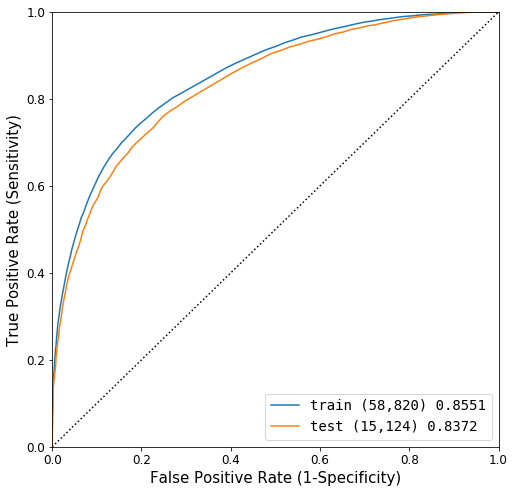

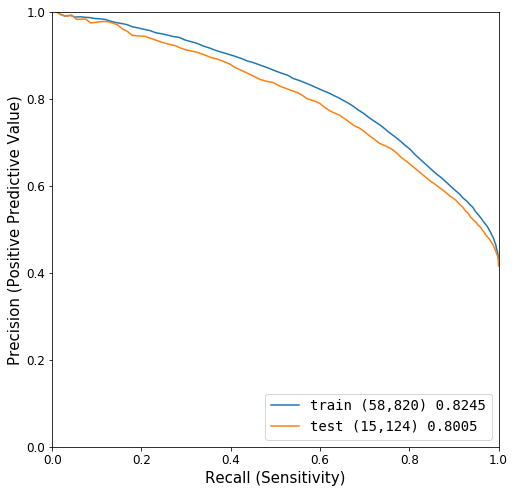

In [34]:
bcm_mlp = BinaryClassificationMetrics()
bcm_mlp.addModel('train', predict_mlp_pd.loc[predict_mlp_pd['train'], ['label','score']])
bcm_mlp.addModel('test', predict_mlp_pd.loc[~predict_mlp_pd['train'], ['label','score']])

bcm_mlp.plotROC(params={'legloc':4})

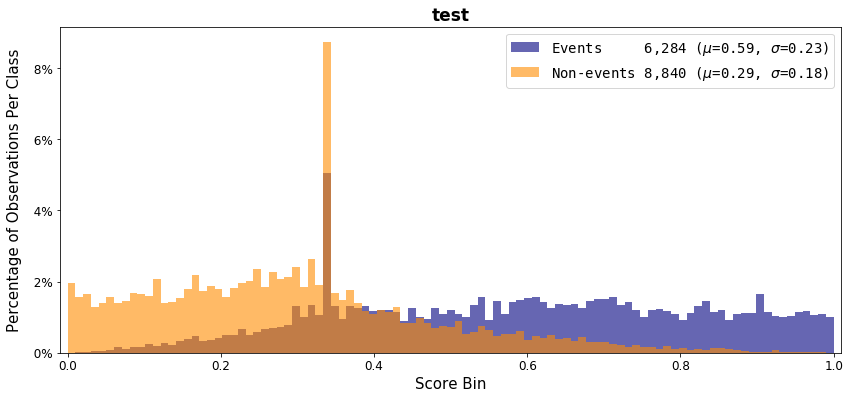

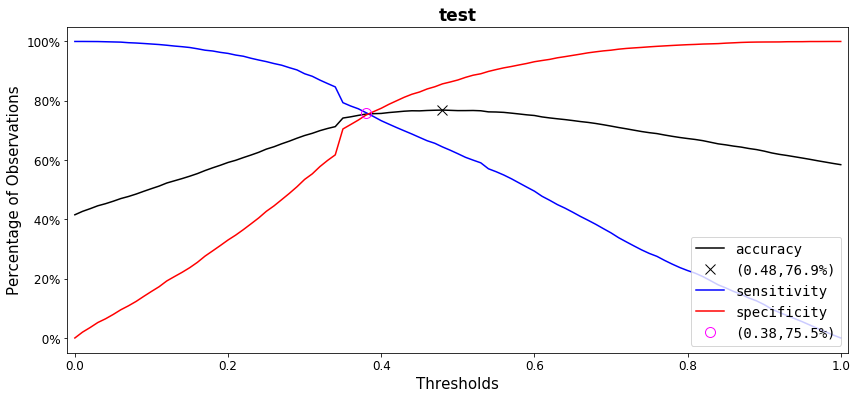

In [35]:
bcm_mlp.plot(model_names=['test'], chart_types=[1,3])

In [36]:
bcm_mlp.confusionMatrixKeyValue(key='f1')

,model,thresh,tp,tn,fp,fn,sens,spec,ppv,npv,accu,prev,lift,f1
0,train,0.38,19278,25957,8117,5468,0.779035,0.761783,0.703705,0.825998,0.769041,0.420707,1.851727,0.739456
1,test,0.38,4776,6644,2196,1508,0.760025,0.751584,0.685026,0.815015,0.755091,0.415499,1.829189,0.720579


In [37]:
del bcm_mlp, model_mlp, predict_mlp_pd

In [38]:
from datetime import datetime
from pytz import timezone
outname = param['NB_NAME'] + datetime.now(timezone('US/Eastern')).strftime(' %Y%m%d-%H%M')

display(Javascript('IPython.notebook.save_checkpoint();'))

!jupyter nbconvert "{param['NB_NAME']}" --to=html --TemplateExporter.exclude_input=True --output-dir={param['DIR']} --output "{outname}"

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook Depression Analysis.ipynb to html
[NbConvertApp] Writing 878419 bytes to ./Depression Analysis 20190511-1822.html
